# **U.S. Domestic Flight Delays and Cancellations**

# **Introduction**

Flight delays and cancellations are common issues in air travel that can impact passengers, airlines, and airport operations.Analyzing historical flight data allows us to identify trends and factors contributing to these disruptions. This project explores a U.S. domestic flight dataset to understand patterns in flight performance, including delays, cancellations, and other key metrics.



🎯 **Project Objectives:**

 - Analyze U.S. domestic flight data to identify delay and cancellation patterns

 - Calculate key performance metrics (e.g., average delays, cancellation rates)

 - Identify the busiest months and days of the week for flights

 - Explore differences in delays across airlines and airports

 - Investigate the most common reasons for flight cancellations

 - Compare delay trends between weekdays and weekends

 - Conduct hypothesis testing to validate observed patterns

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import chi2_contingency, ttest_ind, f_oneway
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

In [14]:
# Load the dataset
df = pd.read_csv(r'/content/flight.csv')
print('shape:' ,df.shape)

shape: (5819079, 31)


In [15]:
df.head(5)

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,2354.0,-11.0,21.0,15.0,205.0,194.0,169.0,1448,404.0,4.0,430,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,2.0,-8.0,12.0,14.0,280.0,279.0,263.0,2330,737.0,4.0,750,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,18.0,-2.0,16.0,34.0,286.0,293.0,266.0,2296,800.0,11.0,806,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,15.0,-5.0,15.0,30.0,285.0,281.0,258.0,2342,748.0,8.0,805,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,24.0,-1.0,11.0,35.0,235.0,215.0,199.0,1448,254.0,5.0,320,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5819079 entries, 0 to 5819078
Data columns (total 31 columns):
 #   Column               Dtype  
---  ------               -----  
 0   YEAR                 int64  
 1   MONTH                int64  
 2   DAY                  int64  
 3   DAY_OF_WEEK          int64  
 4   AIRLINE              object 
 5   FLIGHT_NUMBER        int64  
 6   TAIL_NUMBER          object 
 7   ORIGIN_AIRPORT       object 
 8   DESTINATION_AIRPORT  object 
 9   SCHEDULED_DEPARTURE  int64  
 10  DEPARTURE_TIME       float64
 11  DEPARTURE_DELAY      float64
 12  TAXI_OUT             float64
 13  WHEELS_OFF           float64
 14  SCHEDULED_TIME       float64
 15  ELAPSED_TIME         float64
 16  AIR_TIME             float64
 17  DISTANCE             int64  
 18  WHEELS_ON            float64
 19  TAXI_IN              float64
 20  SCHEDULED_ARRIVAL    int64  
 21  ARRIVAL_TIME         float64
 22  ARRIVAL_DELAY        float64
 23  DIVERTED             int64  
 24

# **Data Cleaning**

In [17]:
# Check for duplicates
print(f"Duplicate rows: {df.duplicated().sum()}")

Duplicate rows: 0


In [18]:
# Check for missing data
missing_data = df.isnull().sum()
missing_percentage = (missing_data / len(df)) * 100

missing_df = pd.DataFrame({
    'Column': missing_data.index,
    'Missing_Count': missing_data.values,
    'Missing_Percentage': missing_percentage.values.round(1)
}).sort_values('Missing_Percentage', ascending=False)

print("Missing Values Analysis:")
print(missing_df[missing_df['Missing_Count'] > 0])

Missing Values Analysis:
                 Column  Missing_Count  Missing_Percentage
25  CANCELLATION_REASON        5729195                98.5
29  LATE_AIRCRAFT_DELAY        4755640                81.7
30        WEATHER_DELAY        4755640                81.7
28        AIRLINE_DELAY        4755640                81.7
26     AIR_SYSTEM_DELAY        4755640                81.7
27       SECURITY_DELAY        4755640                81.7
15         ELAPSED_TIME         105071                 1.8
16             AIR_TIME         105071                 1.8
22        ARRIVAL_DELAY         105071                 1.8
18            WHEELS_ON          92513                 1.6
19              TAXI_IN          92513                 1.6
21         ARRIVAL_TIME          92513                 1.6
12             TAXI_OUT          89047                 1.5
13           WHEELS_OFF          89047                 1.5
10       DEPARTURE_TIME          86153                 1.5
11      DEPARTURE_DELAY        

# **Exloratory Data Analysis**

In [19]:
# Flight operations
df['DATE'] = pd.to_datetime(df[['YEAR', 'MONTH', 'DAY']])

total_flights = len(df)
cancelled_flights = df['CANCELLED'].sum()
diverted_flights = df['DIVERTED'].sum()
on_time_flights = len(df[(df['DEPARTURE_DELAY'] <= 0) & (df['CANCELLED'] == 0)])

print(f"Total Flights: {total_flights:,}")
print(f"Cancelled Flights: {cancelled_flights:,} ({cancelled_flights/total_flights*100:.2f}%)")
print(f"Diverted Flights: {diverted_flights:,} ({diverted_flights/total_flights*100:.2f}%)")
print(f"On-time Flights: {on_time_flights:,} ({on_time_flights/total_flights*100:.2f}%)")

Total Flights: 5,819,079
Cancelled Flights: 89,884 (1.54%)
Diverted Flights: 15,187 (0.26%)
On-time Flights: 3,606,117 (61.97%)


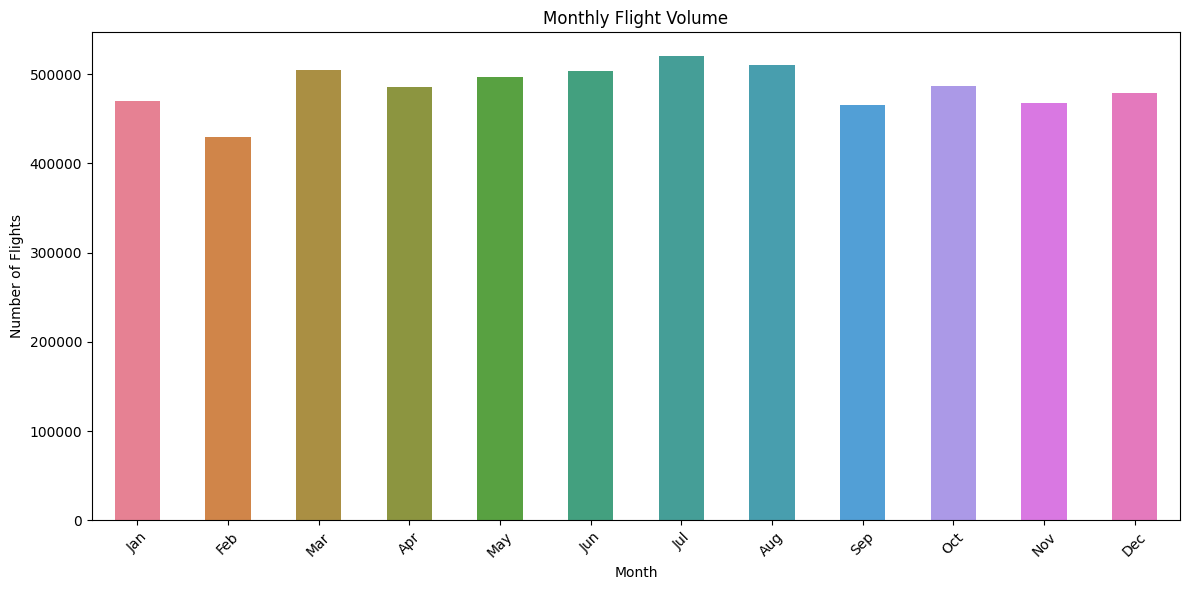

In [20]:
# Monthly flight volume
monthly_flights = df.groupby('MONTH').size().reset_index(name='Flight_Count')
monthly_flights['Month_Name'] = monthly_flights['MONTH'].map({
    1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
    7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'
})

plt.figure(figsize=(12, 6))
sns.barplot(data=monthly_flights, x='Month_Name', y='Flight_Count', palette='husl', width=0.5)
plt.xlabel('Month')
plt.title('Monthly Flight Volume')
plt.ylabel('Number of Flights')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

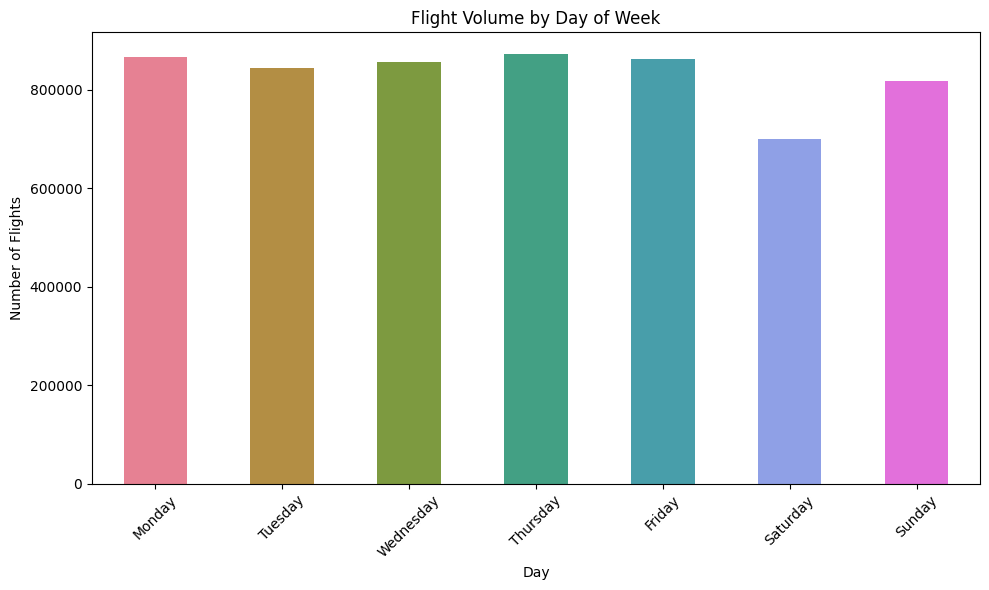

In [21]:
# Flight Volume by Day of Week
dow_flights = df.groupby('DAY_OF_WEEK').size().reset_index(name='Flight_Count')
dow_names = {1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday',
             5: 'Friday', 6: 'Saturday', 7: 'Sunday'}
dow_flights['Day_Name'] = dow_flights['DAY_OF_WEEK'].map(dow_names)

plt.figure(figsize=(10, 6))
sns.barplot(data=dow_flights, x='Day_Name', y='Flight_Count',palette='husl', width=0.5)
plt.title('Flight Volume by Day of Week')
plt.xlabel('Day')
plt.ylabel('Number of Flights')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# **Airline Analysis**

In [22]:
# Airline Analysis
airline_stats = df.groupby('AIRLINE').agg({
    'FLIGHT_NUMBER': 'count',
    'DEPARTURE_DELAY': 'mean',
    'ARRIVAL_DELAY': 'mean',
    'CANCELLED': 'sum',
    'DIVERTED': 'sum'}).round(2)

airline_stats.columns = ['Total_Flights', 'Avg_Departure_Delay', 'Avg_Arrival_Delay', 'Cancelled_Flights', 'Diverted_Flights']
airline_stats = airline_stats.sort_values('Total_Flights', ascending=False)

print('Top 10 Airlines by Flight Volume:')
print(airline_stats.head(10))

Top 10 Airlines by Flight Volume:
         Total_Flights  Avg_Departure_Delay  Avg_Arrival_Delay  \
AIRLINE                                                          
WN             1261855                10.58               4.37   
DL              875881                 7.37               0.19   
AA              725984                 8.90               3.45   
OO              588353                 7.80               5.85   
EV              571977                 8.72               6.59   
UA              515723                14.44               5.43   
MQ              294632                10.13               6.46   
B6              267048                11.51               6.68   
US              198715                 6.14               3.71   
AS              172521                 1.79              -0.98   

         Cancelled_Flights  Diverted_Flights  
AIRLINE                                       
WN                   16043              3409  
DL                    3824      

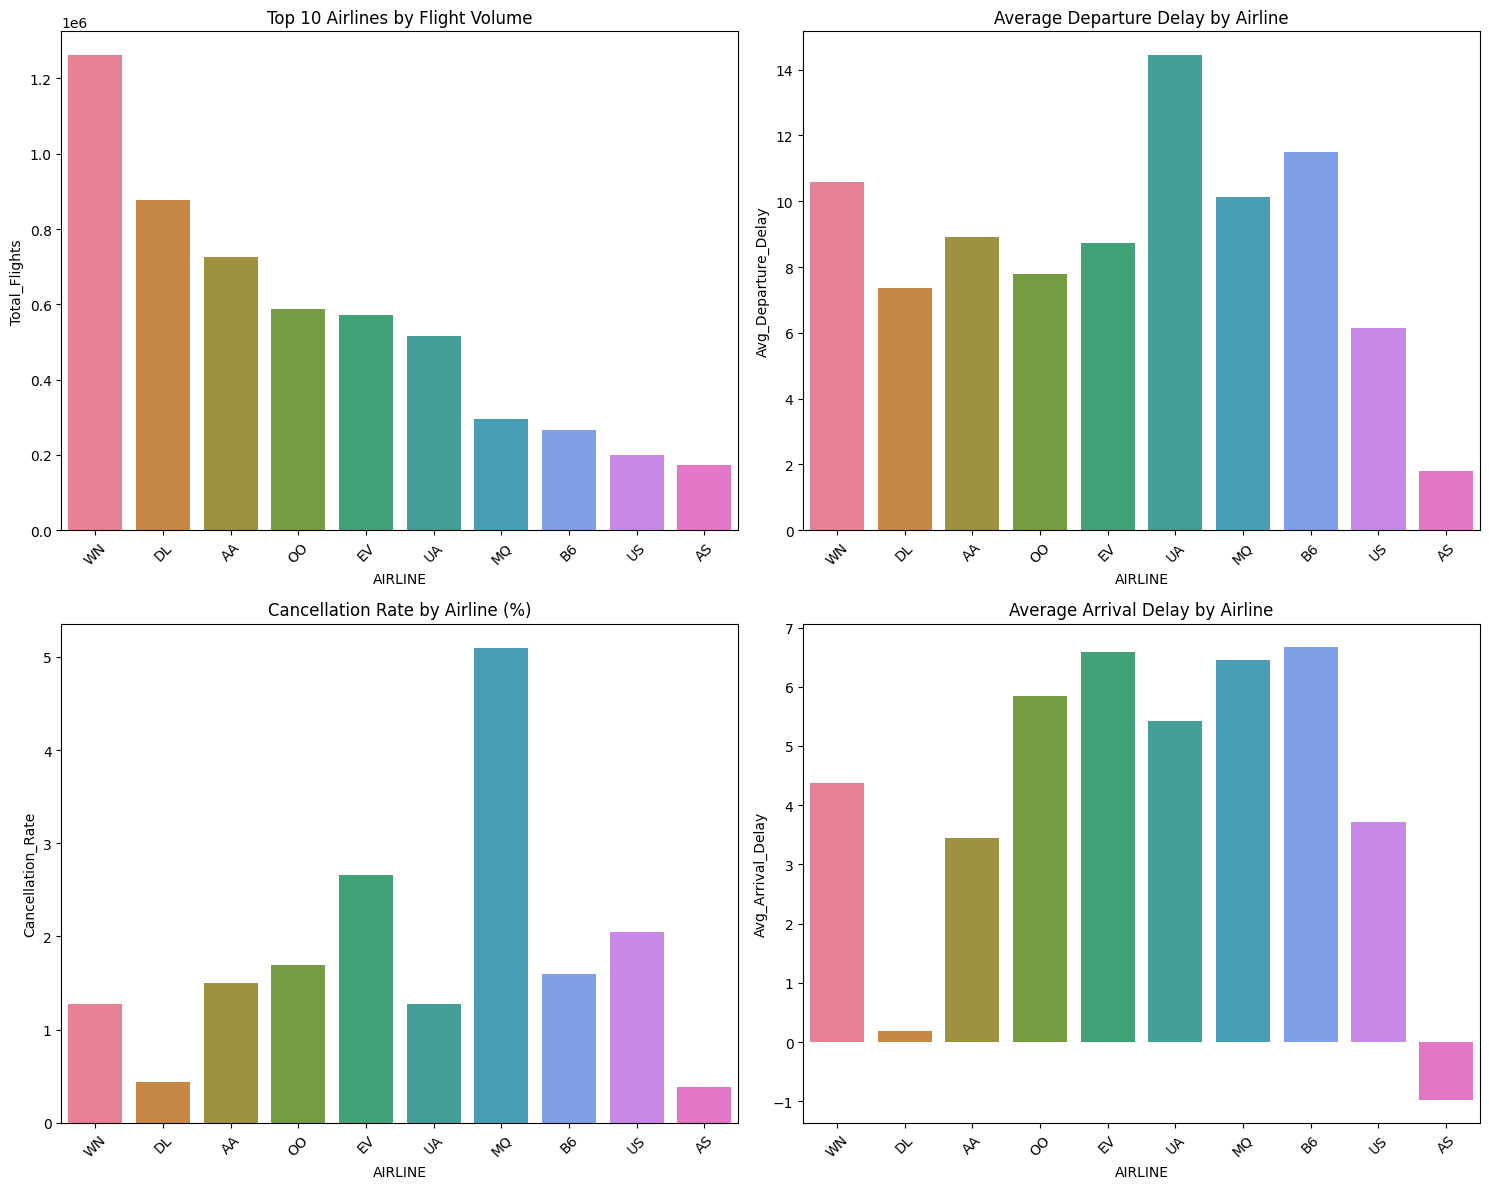

In [23]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Flight volume
top_airlines = airline_stats.head(10)
sns.barplot(data=top_airlines.reset_index(), x='AIRLINE', y='Total_Flights', ax=axes[0,0], palette='husl')
axes[0,0].set_title('Top 10 Airlines by Flight Volume')
axes[0,0].tick_params(axis='x', rotation=45)

# Average departure delay
sns.barplot(data=top_airlines.reset_index(), x='AIRLINE', y='Avg_Departure_Delay', ax=axes[0,1], palette='husl')
axes[0,1].set_title('Average Departure Delay by Airline')
axes[0,1].tick_params(axis='x', rotation=45)

# Cancellation rate
top_airlines['Cancellation_Rate'] = (top_airlines['Cancelled_Flights'] / top_airlines['Total_Flights']) * 100
sns.barplot(data=top_airlines.reset_index(), x='AIRLINE', y='Cancellation_Rate', ax=axes[1,0], palette='husl')
axes[1,0].set_title('Cancellation Rate by Airline (%)')
axes[1,0].tick_params(axis='x', rotation=45)

# Average arrival delay
sns.barplot(data=top_airlines.reset_index(), x='AIRLINE', y='Avg_Arrival_Delay', ax=axes[1,1], palette='husl')
axes[1,1].set_title('Average Arrival Delay by Airline')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


# **Delay Analysis**

In [24]:
# Filter out cancelled flights for delay analysis
active_flights = df[df['CANCELLED'] == 0]

active_flights = active_flights[active_flights['DEPARTURE_DELAY'].notna()]
active_flights['WEEKEND'] = active_flights['DAY_OF_WEEK'].isin([6, 7])

weekend_delay = active_flights.groupby('WEEKEND')['DEPARTURE_DELAY'].mean().rename(index={False: 'Weekday', True: 'Weekend'}).round(1)

print("\n📅 Avg Departure Delay (Weekend vs Weekday):")
for day_type, delay in weekend_delay.items():
    print(f"{day_type}: {delay} minutes")


📅 Avg Departure Delay (Weekend vs Weekday):
Weekday: 9.6 minutes
Weekend: 8.6 minutes


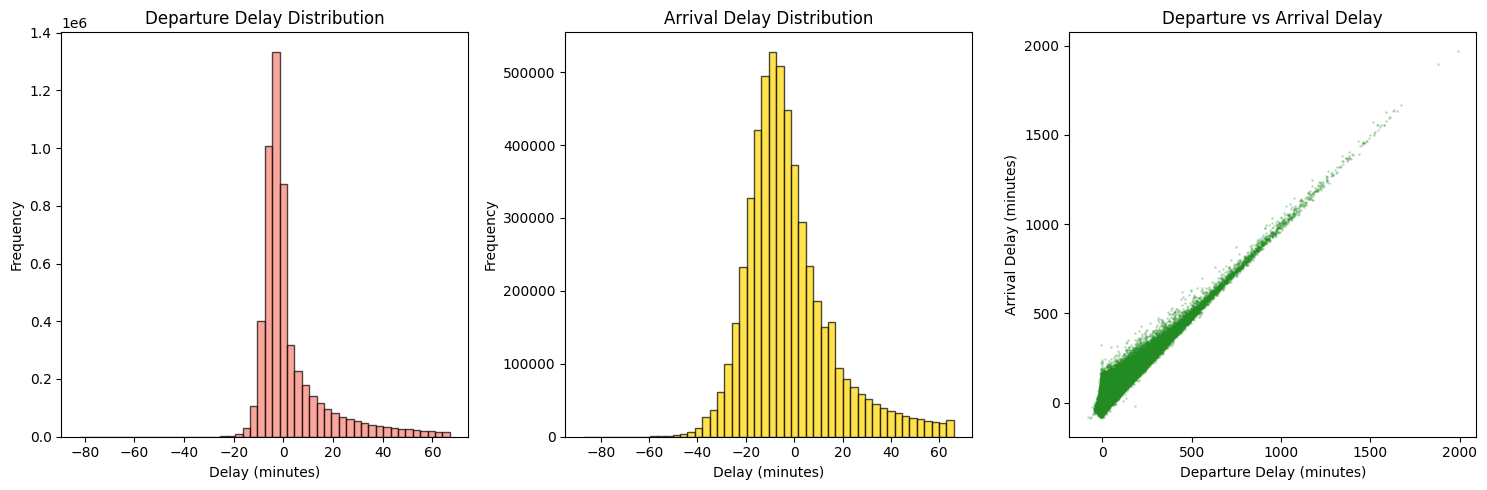

In [25]:
# Departure delay distribution
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
# Remove extreme outliers for better visualization
delay_percentile = np.percentile(active_flights['DEPARTURE_DELAY'].dropna(), 95)
delay_data = active_flights[active_flights['DEPARTURE_DELAY'] <= delay_percentile]['DEPARTURE_DELAY']
plt.hist(delay_data, bins=50, alpha=0.7, color='salmon', edgecolor='black')
plt.title('Departure Delay Distribution')
plt.xlabel('Delay (minutes)')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
arrival_delay_percentile = np.percentile(active_flights['ARRIVAL_DELAY'].dropna(), 95)
arrival_delay_data = active_flights[active_flights['ARRIVAL_DELAY'] <= arrival_delay_percentile]['ARRIVAL_DELAY']
plt.hist(arrival_delay_data, bins=50, alpha=0.7, edgecolor='black', color='gold')
plt.title('Arrival Delay Distribution')
plt.xlabel('Delay (minutes)')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
plt.scatter(active_flights['DEPARTURE_DELAY'], active_flights['ARRIVAL_DELAY'], alpha=0.2, s=1, color='forestgreen')
plt.title('Departure vs Arrival Delay')
plt.xlabel('Departure Delay (minutes)')
plt.ylabel('Arrival Delay (minutes)')

plt.tight_layout()
plt.show()

🛣️  Top 15 Most Popular Routes:
ROUTE
SFOLAX    13744
LAXSFO    13457
JFKLAX    12016
LAXJFK    12015
LASLAX     9715
LGAORD     9639
LAXLAS     9594
ORDLGA     9575
SFOJFK     8440
JFKSFO     8437
OGGHNL     8313
HNLOGG     8282
LAXORD     8256
ATLLGA     8234
LGAATL     8215
Name: count, dtype: int64


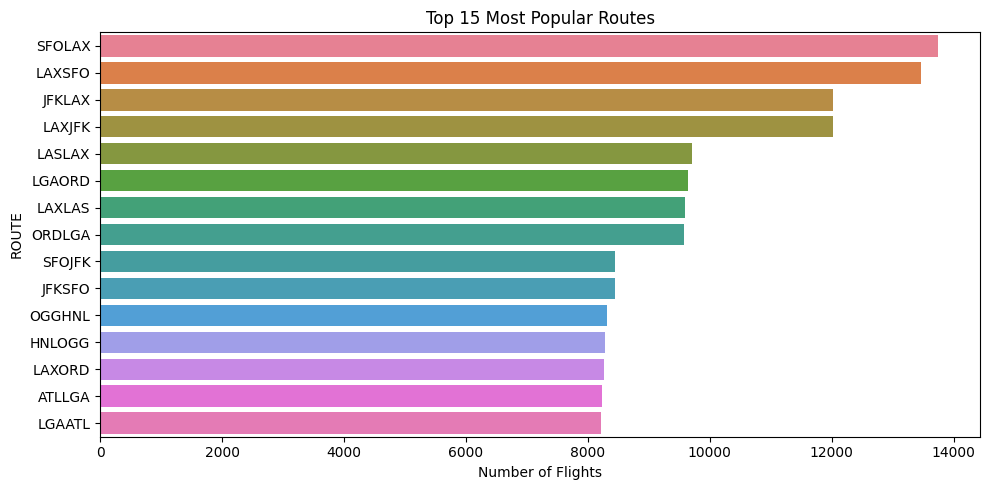

In [26]:
# Route Analysis
df['ROUTE'] = df['ORIGIN_AIRPORT']  + df['DESTINATION_AIRPORT']

# Most popular routes
popular_routes = df['ROUTE'].value_counts().head(15)
print("🛣️  Top 15 Most Popular Routes:")
print(popular_routes)

plt.figure(figsize=(10, 5))
sns.barplot(x=popular_routes.values, y=popular_routes.index, palette='husl')
plt.title('Top 15 Most Popular Routes')
plt.xlabel('Number of Flights')
plt.tight_layout()
plt.show()

In [27]:
# Busiest airports
print("\n🏢 Busiest Origin Airports:")
busiest_origins = df['ORIGIN_AIRPORT'].value_counts().head(10)
print(busiest_origins)
print("\n🏢 Busiest Destination Airports:")
busiest_destinations = df['DESTINATION_AIRPORT'].value_counts().head(10)
print(busiest_destinations)


🏢 Busiest Origin Airports:
ORIGIN_AIRPORT
ATL    346836
ORD    285884
DFW    239551
DEN    196055
LAX    194673
SFO    148008
PHX    146815
IAH    146622
LAS    133181
MSP    112117
Name: count, dtype: int64

🏢 Busiest Destination Airports:
DESTINATION_AIRPORT
ATL    346904
ORD    285906
DFW    239582
DEN    196010
LAX    194696
SFO    147966
PHX    146812
IAH    146683
LAS    133198
MSP    112128
Name: count, dtype: int64


In [28]:
# Airport performance
airport_performance = active_flights.groupby('ORIGIN_AIRPORT').agg({
    'FLIGHT_NUMBER': 'count',
    'DEPARTURE_DELAY': 'mean',
    'DISTANCE': 'mean'}).round(2)
airport_performance.columns = ['Total_Flights', 'Avg_Departure_Delay', 'Avg_Distance']
airport_performance = airport_performance.sort_values('Total_Flights', ascending=False)

print("\n Top 10 Airport Performance:")
print(airport_performance.head(10))


 Top 10 Airport Performance:
                Total_Flights  Avg_Departure_Delay  Avg_Distance
ORIGIN_AIRPORT                                                  
ATL                    344279                 9.33        640.29
ORD                    277336                14.07        722.45
DFW                    233297                11.44        787.67
DEN                    193932                11.81        876.69
LAX                    192509                10.65       1252.54
PHX                    145913                 8.65        967.19
SFO                    145860                11.17       1201.66
IAH                    144492                11.52        826.25
LAS                    132245                10.94        997.37
MSP                    111309                 7.24        810.71


# **Distance Analysis**

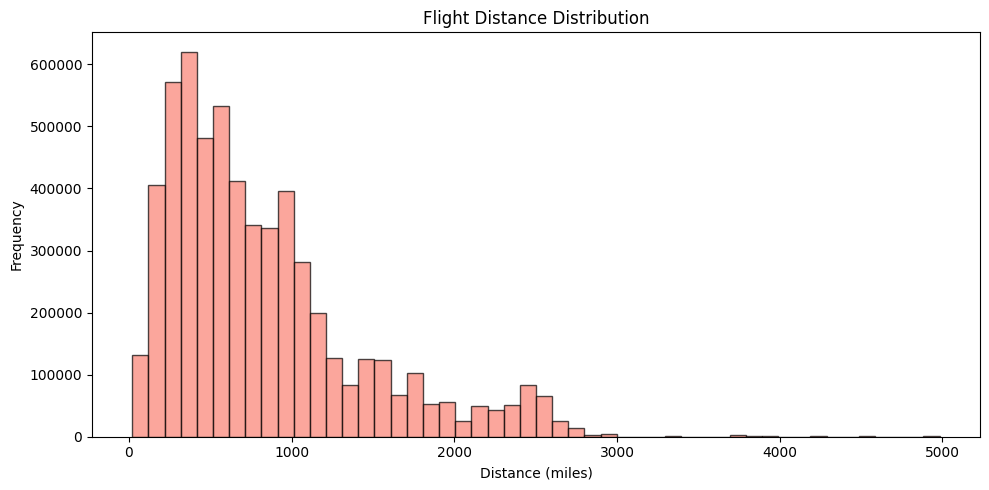

In [29]:
# Distance
plt.figure(figsize=(10, 5))
plt.hist(df['DISTANCE'], bins=50, alpha=0.7, color='salmon', edgecolor='black')
plt.title('Flight Distance Distribution')
plt.xlabel('Distance (miles)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# **Delay Analysis**

🕐 Delay Causes Analysis:
       AIR_SYSTEM_DELAY  SECURITY_DELAY  AIRLINE_DELAY  LATE_AIRCRAFT_DELAY  \
count     950873.000000   950873.000000  950873.000000        950873.000000   
mean          11.977555        0.085162      21.177720            26.251593   
std           28.777464        2.266605      50.467607            44.876877   
min            0.000000        0.000000       0.000000             0.000000   
25%            0.000000        0.000000       0.000000             0.000000   
50%            0.000000        0.000000       5.000000             9.000000   
75%           13.000000        0.000000      21.000000            33.000000   
max         1134.000000      573.000000    1971.000000          1331.000000   

       WEATHER_DELAY  
count  950873.000000  
mean        3.245295  
std        21.575930  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         0.000000  
max      1211.000000  

📊 Average Delay by Cause:
LATE_AIRCRAFT_DELAY    26.251

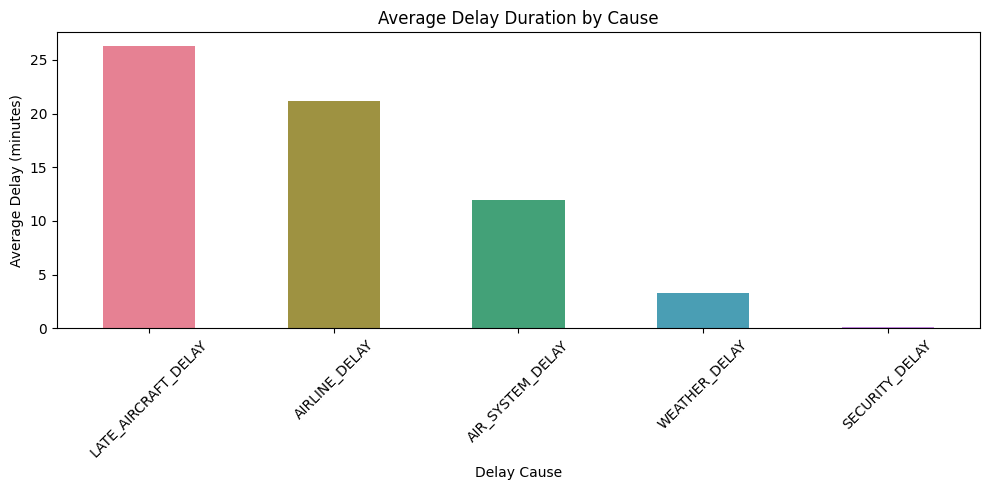

In [30]:
# Analyze delay causes (only for flights with delays)
delay_causes = ['AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY',
                'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY']

delayed_flights = active_flights[active_flights['DEPARTURE_DELAY'] > 0]

print("🕐 Delay Causes Analysis:")
cause_stats = delayed_flights[delay_causes].describe()
print(cause_stats)

# Average delay by cause
avg_delays_by_cause = delayed_flights[delay_causes].mean().sort_values(ascending=False)
print("\n📊 Average Delay by Cause:")
print(avg_delays_by_cause)

plt.figure(figsize=(10, 5))
sns.barplot(x=avg_delays_by_cause.index, y=avg_delays_by_cause.values, palette = 'husl', width=0.5)
plt.title('Average Delay Duration by Cause')
plt.xlabel('Delay Cause')
plt.ylabel('Average Delay (minutes)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

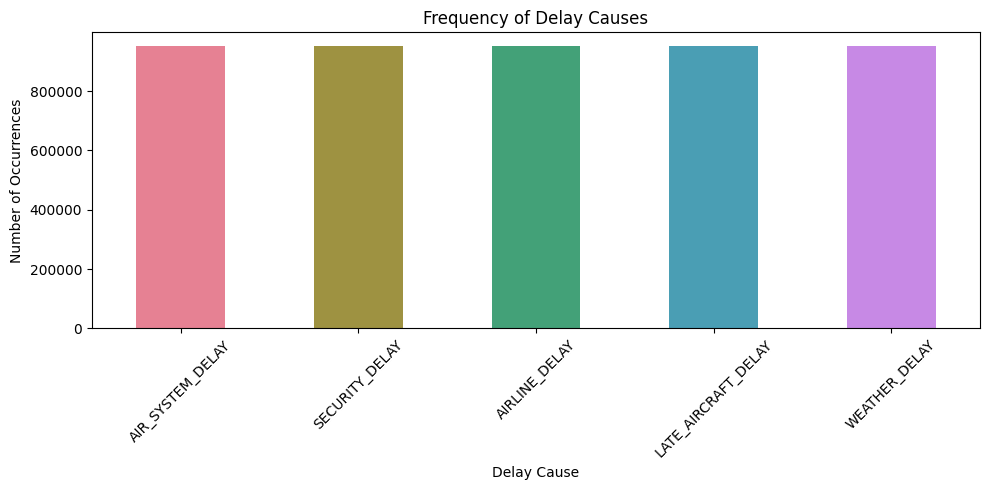

In [33]:
# Delay cause frequency
cause_frequency = delayed_flights[delay_causes].count().sort_values(ascending=False)
plt.figure(figsize=(10, 5))
sns.barplot(x=cause_frequency.index, y=cause_frequency.values, palette='husl', width=0.5)
plt.title('Frequency of Delay Causes')
plt.xlabel('Delay Cause')
plt.ylabel('Number of Occurrences')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# **Cancellation Analysis**

❌ Total Cancelled Flights: 89,884

📋 Cancellation Reasons:
CANCELLATION_REASON
B    48851
A    25262
C    15749
D       22
Name: count, dtype: int64

🏢 Top 10 Airlines by Cancellations:
AIRLINE
WN    16043
EV    15231
MQ    15025
AA    10919
OO     9960
UA     6573
B6     4276
US     4067
DL     3824
NK     2004
dtype: int64


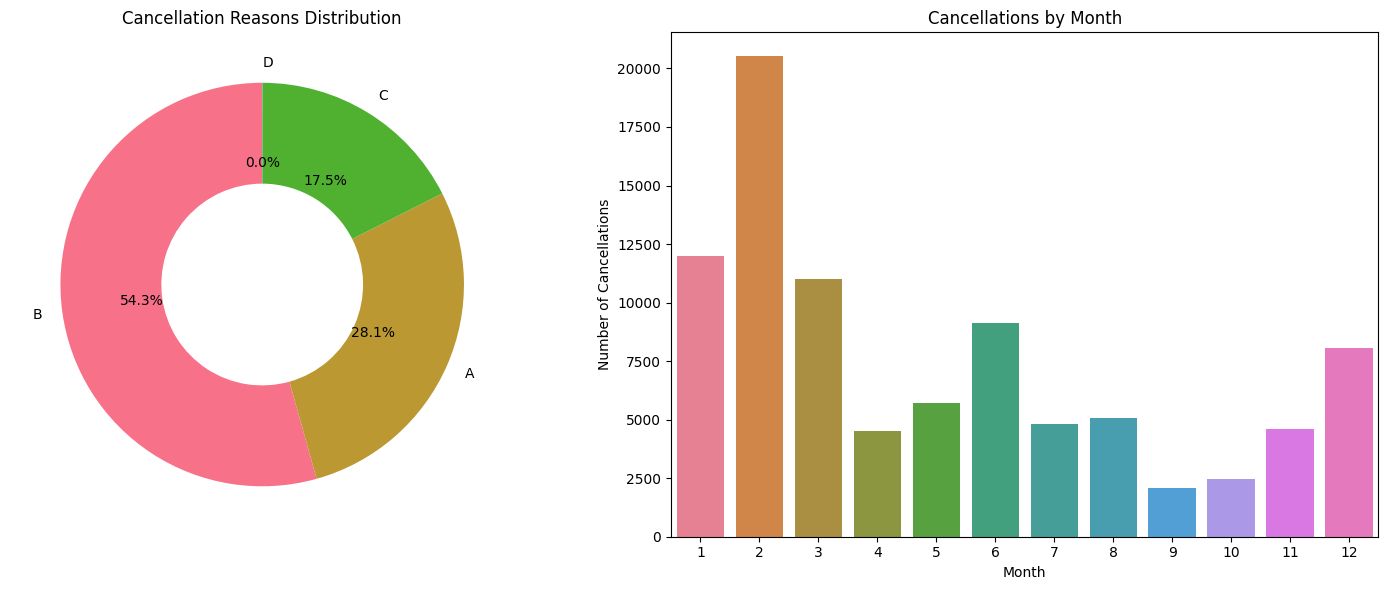

In [35]:
# Filter cancelled flights
cancelled_flights_df = df[df['CANCELLED'] == 1]

if len(cancelled_flights_df) > 0:
    print(f"❌ Total Cancelled Flights: {len(cancelled_flights_df):,}")

    # Cancellation reasons
    cancellation_reasons = cancelled_flights_df['CANCELLATION_REASON'].value_counts()
    print("\n📋 Cancellation Reasons:")
    print(cancellation_reasons)

    # Cancellation by airline
    airline_cancellations = cancelled_flights_df.groupby('AIRLINE').size().sort_values(ascending=False)
    print("\n🏢 Top 10 Airlines by Cancellations:")
    print(airline_cancellations.head(10))

    colors= sns.color_palette('husl')
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Cancellation reasons donut chart
    if not cancellation_reasons.empty:
        axes[0].pie(cancellation_reasons.values, labels=cancellation_reasons.index, autopct='%1.1f%%', startangle=90,wedgeprops={'width': 0.5},colors=colors )
        axes[0].set_title('Cancellation Reasons Distribution')

    # Monthly cancellations bar chart
    monthly_cancellations = cancelled_flights_df.groupby('MONTH').size()
    sns.barplot(x=monthly_cancellations.index, y=monthly_cancellations.values, ax=axes[1], palette='husl')
    axes[1].set_title('Cancellations by Month')
    axes[1].set_xlabel('Month')
    axes[1].set_ylabel('Number of Cancellations')

    plt.tight_layout()
    plt.show()

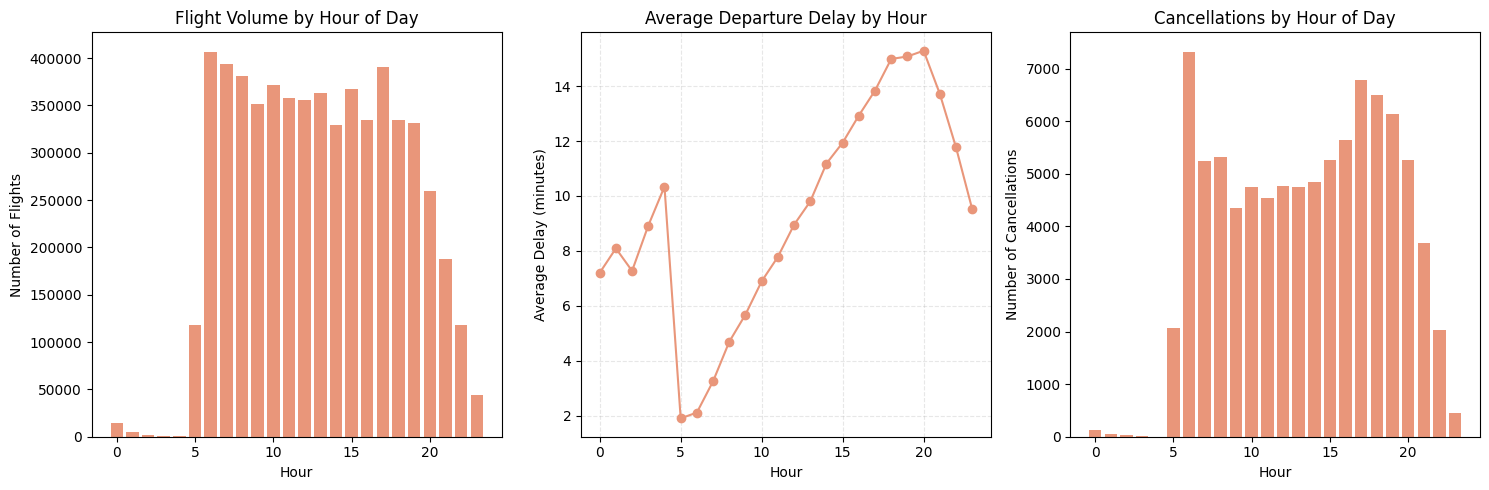

In [36]:
#Hour of day analysis (from scheduled departure)
df['DEPARTURE_HOUR'] = (df['SCHEDULED_DEPARTURE'] // 100).astype(int)
hourly_patterns = df.groupby('DEPARTURE_HOUR').agg({
    'FLIGHT_NUMBER': 'count',
    'DEPARTURE_DELAY': 'mean',
    'CANCELLED': 'sum'
}).round(2)

hourly_patterns.columns = ['Flight_Count', 'Avg_Delay', 'Cancellations']

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.bar(hourly_patterns.index, hourly_patterns['Flight_Count'], color='darksalmon')
plt.title('Flight Volume by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Number of Flights')

plt.subplot(1, 3, 2)
plt.plot(hourly_patterns.index, hourly_patterns['Avg_Delay'], marker='o',color='darksalmon')
plt.title('Average Departure Delay by Hour')
plt.xlabel('Hour')
plt.ylabel('Average Delay (minutes)')
plt.grid(linestyle='--', alpha=0.3)

plt.subplot(1, 3, 3)
plt.bar(hourly_patterns.index, hourly_patterns['Cancellations'], color='darksalmon')
plt.title('Cancellations by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Number of Cancellations')

plt.tight_layout()
plt.show()

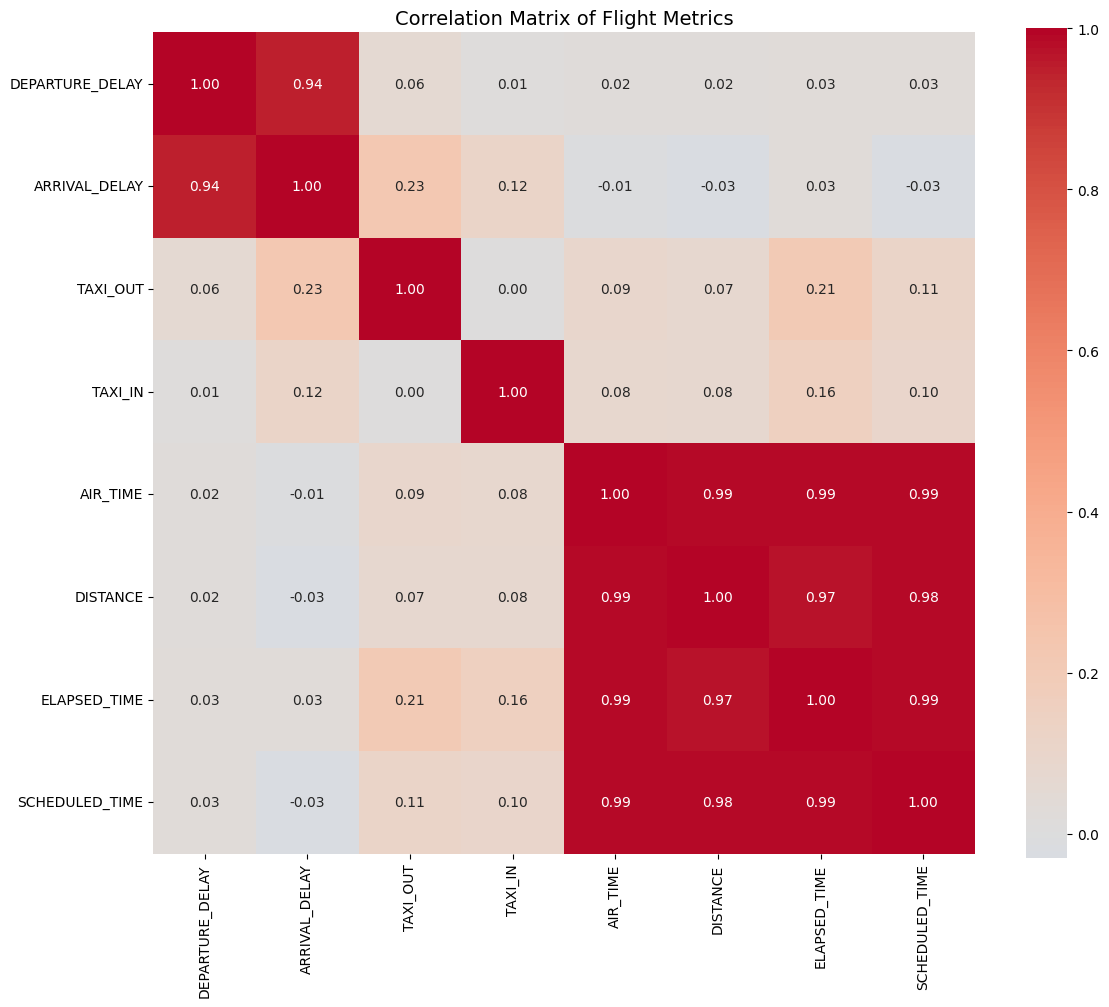

In [39]:
# Correlation Analysis
numeric_cols = ['DEPARTURE_DELAY', 'ARRIVAL_DELAY', 'TAXI_OUT', 'TAXI_IN',
                'AIR_TIME', 'DISTANCE', 'ELAPSED_TIME', 'SCHEDULED_TIME']

correlation_matrix = active_flights[numeric_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.2f')
plt.title('Correlation Matrix of Flight Metrics', fontsize=14)
plt.tight_layout()
plt.show()


# **Hypothesis Testing**

In [40]:
alpha = 0.05

In [41]:
# T-TEST: Weekend vs Weekday Departure Delay
active_flights['WEEKEND'] = active_flights['DAY_OF_WEEK'].isin([6, 7])

weekday_delays = active_flights[active_flights['WEEKEND'] == False]['DEPARTURE_DELAY']
weekend_delays = active_flights[active_flights['WEEKEND'] == True]['DEPARTURE_DELAY']

t_stat, p_value = ttest_ind(weekday_delays, weekend_delays, equal_var=False)

print("\nHypothesis Test: Weekend vs Weekday Departure Delay")
print(f"T-statistic: {t_stat:.3f}")
print(f"P-value: {p_value:.4f}")
if p_value < alpha:
    print("Result: Statistically significant difference in departure delays between weekends and weekdays.")
else:
    print("Result: No statistically significant difference in departure delays between weekends and weekdays.")


Hypothesis Test: Weekend vs Weekday Departure Delay
T-statistic: 27.086
P-value: 0.0000
Result: Statistically significant difference in departure delays between weekends and weekdays.


In [43]:
# ANOVA: Departure Delays Across Top Airlines
top_airlines = df['AIRLINE'].value_counts().head(10).index.tolist()
delay_groups = [active_flights[active_flights['AIRLINE'] == airline]['DEPARTURE_DELAY'].dropna() for airline in top_airlines]

f_stat, p_val = f_oneway(*delay_groups)

print("\nANOVA Test: Departure Delays Across Top Airlines")
print(f"F-statistic: {f_stat:.3f}")
print(f"P-value: {p_val:.4f}")
if p_val < alpha:
    print("Result: Significant difference in mean departure delays across airlines.")
else:
    print("Result: No significant difference in mean departure delays across airlines.")


ANOVA Test: Departure Delays Across Top Airlines
F-statistic: 2749.530
P-value: 0.0000
Result: Significant difference in mean departure delays across airlines.


In [44]:
# Chi-Square Test: Cancellation Rates by Airline
cancellation_table = pd.crosstab(df['AIRLINE'], df['CANCELLED'])
chi2, p, dof, expected = chi2_contingency(cancellation_table)

print("\nChi-Square Test: Cancellation Rates by Airline")
print(f"Chi2 statistic: {chi2:.3f}")
print(f"P-value: {p:.4f}")
if p < alpha:
    print("Result: Cancellation rates depend on airline.")
else:
    print("Result: Cancellation rates do not depend on airline.")


Chi-Square Test: Cancellation Rates by Airline
Chi2 statistic: 40636.106
P-value: 0.0000
Result: Cancellation rates depend on airline.


In [45]:
# T-TEST: Departure Delays Diverted vs Non-Diverted Flights
diverted_delays = df[df['DIVERTED'] == 1]['DEPARTURE_DELAY'].dropna()
non_diverted_delays = df[df['DIVERTED'] == 0]['DEPARTURE_DELAY'].dropna()

t_stat, p_val = ttest_ind(diverted_delays, non_diverted_delays, equal_var=False)

print("\nT-Test: Departure Delays Diverted vs Non-Diverted Flights")
print(f"T-statistic: {t_stat:.3f}")
print(f"P-value: {p_val:.4f}")
if p_val < alpha:
    print("Result: Significant difference in departure delays between diverted and non-diverted flights.")
else:
    print("Result: No significant difference in departure delays between diverted and non-diverted flights.")


T-Test: Departure Delays Diverted vs Non-Diverted Flights
T-statistic: 32.468
P-value: 0.0000
Result: Significant difference in departure delays between diverted and non-diverted flights.


In [46]:
# Chi-Square Test: Cancellation Rates Weekend vs Weekday
df['WEEKEND'] = df['DAY_OF_WEEK'].isin([6, 7])
cancellation_weekend_table = pd.crosstab(df['WEEKEND'], df['CANCELLED'])
chi2, p, dof, expected = chi2_contingency(cancellation_weekend_table)

print("\nChi-Square Test: Cancellation Rates Weekend vs Weekday")
print(f"Chi2 statistic: {chi2:.3f}")
print(f"P-value: {p:.4f}")
if p < alpha:
    print("Result: Cancellation rates depend on weekend vs weekday.")
else:
    print("Result: Cancellation rates do not depend on weekend vs weekday.")



Chi-Square Test: Cancellation Rates Weekend vs Weekday
Chi2 statistic: 138.601
P-value: 0.0000
Result: Cancellation rates depend on weekend vs weekday.




# **Key Insights**

In [47]:
# key metrics
avg_departure_delay = active_flights['DEPARTURE_DELAY'].mean()
avg_arrival_delay = active_flights['ARRIVAL_DELAY'].mean()
cancellation_rate = (cancelled_flights / total_flights) * 100
diverted_rate = (diverted_flights / total_flights) * 100
busiest_month = monthly_flights.loc[monthly_flights['Flight_Count'].idxmax(), 'Month_Name']
worst_delay_airline = airline_stats.loc[airline_stats['Avg_Departure_Delay'].idxmax()].name

# Percentage of on-time departures (departure delay ≤ 0)
on_time_percentage = (len(active_flights[active_flights['DEPARTURE_DELAY'] <= 0]) / total_flights) * 100

# Busiest day of the week
busiest_day_num = df['DAY_OF_WEEK'].value_counts().idxmax()
dow_names = {1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday',
             5: 'Friday', 6: 'Saturday', 7: 'Sunday'}
busiest_day_name = dow_names[busiest_day_num]

# Airport with highest average departure delay
worst_airport = airport_performance['Avg_Departure_Delay'].idxmax()
worst_airport_delay = airport_performance.loc[worst_airport, 'Avg_Departure_Delay']

# Most common cancellation reason
if len(cancelled_flights_df) > 0:
    top_cancel_reason = cancellation_reasons.idxmax()
else:
    top_cancel_reason = "N/A"

print(f"✈️  Average departure delay: {avg_departure_delay:.1f} minutes")
print(f"✈️  Average arrival delay: {avg_arrival_delay:.1f} minutes")
print(f"❌ Overall cancellation rate: {cancellation_rate:.2f}%")
print(f"🔀 Percentage of diverted flights: {diverted_rate:.2f}%")
print(f"⏰ Percentage of on-time departures: {on_time_percentage:.2f}%")
print(f"📅 Busiest month: {busiest_month}")
print(f"📅 Busiest day of the week: {busiest_day_name}")
print(f"🏢 Airline with highest average departure delay: {worst_delay_airline}")
print(f"🏢 Airport with highest average departure delay: {worst_airport} ({worst_airport_delay:.1f} mins)")
print(f"❌ Most common cancellation reason: {top_cancel_reason}")

✈️  Average departure delay: 9.3 minutes
✈️  Average arrival delay: 4.4 minutes
❌ Overall cancellation rate: 1.54%
🔀 Percentage of diverted flights: 0.26%
⏰ Percentage of on-time departures: 61.97%
📅 Busiest month: Jul
📅 Busiest day of the week: Thursday
🏢 Airline with highest average departure delay: NK
🏢 Airport with highest average departure delay: 14960 (155.2 mins)
❌ Most common cancellation reason: B
